<a href="https://colab.research.google.com/github/greymouse1/Kalman-filter/blob/main/Kalman_for_end_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyproj


In [ ]:
import numpy as np
import csv
from datetime import datetime
import math
import matplotlib.pyplot as plt
import pyproj
import pandas as pd
import statistics as stat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This chunk of code will take out all timestamps, and calculate time differences
#between current and previous timestamp
#Import csv files
filename = "/content/drive/MyDrive/ColabNotebooks_shared/ShipRouting/nikola_test/IMO10022205_end_prediction.csv"
with open (filename) as csv_file:
  ship1_csv = csv.reader(csv_file, delimiter = ",")
  time_holder = []
  differences_holder = []
  timestamps = []
  # create array with timestamps
  for line_count,row in enumerate(ship1_csv,0):
    if line_count > 0:            # jumps over first row since first row is only description
      time_holder.append(row[2])  # select time which lies on index 2 in csv file

  # parse timestamps and calculate time difference between current and prevous point
  fmt = '%Y-%m-%d %H:%M:%S'
  for i in range(1,len(time_holder)):
    tstamp1 = datetime.strptime(time_holder[i-1], fmt)
    tstamp2 = datetime.strptime(time_holder[i], fmt)
    if tstamp2 > tstamp1:
      diff = tstamp2 - tstamp1
      diff = diff.total_seconds()
    else:
      diff = tstamp1 - tstamp2
      diff = diff.total_seconds()
    differences_holder.append(diff)


In [ ]:
# This chunk of code will create zk_vector_holder with sensor readings(lat,lon,cog) and 
# control_vector_holder with speed of boat and angular speed

# Import csv files
with open (filename) as csv_file:
  ship1_csv = csv.reader(csv_file, delimiter = ",")
  zk_vector_holder = []
  control_vector_holder = []
  for line_count,row in enumerate(ship1_csv,0):
    if line_count > 0: #starts populating from first AIS message
      
      # create zk vector with sensor readings
      if float(row[   6]) < 0:
        angle = 360 + float(row[6])
      else:
        angle = float(row[6])
      angle_rad = (angle*math.pi)/180
      
      # convert LAT(y), LON(x) to N(y),E(x)
      proj = pyproj.Transformer.from_crs(4326, 2831, always_xy=True)
      lon1, lat1 = (float(row[4]), float(row[3]))
      easting, northing = proj.transform(lon1, lat1)
      
      # append converted coordinates
      zk_vector_holder.append([easting,northing,angle_rad]) #holder for E,N and COG
    
    if line_count > 1: #starts populating from second AIS message
      angle_difference = angle_rad - zk_vector_holder[line_count-2][2]
      
      # populate control vector with speed(m/s) and angular speed(rad/s)
      control_vector_holder.append([(float(row[5]))*0.5144,angle_difference/differences_holder[line_count-2]]) #holder for speed and angular speed
  
  zk_vector_holder.pop(0)

In [ ]:
# Since zk_vector_holder is used as a source of observations, it will be needed
# for calculations inside Kalman filter. As we will be doing predictions, we
# need to replace some of these observations with [0,0,0] inside zk_vector_holder
# so when Kalman filter encounters zeores, it will make predictions.
# We still need original observations for comparison, hence we make a copy of
# zk_vector_holder which will be used for calculating delta_x and delta_y between
# observation and prediction, and for plotting original observations as well
# We need to make a deep copy of original array, so subsequent changes on original
# array (zk_vector_holder) don't change our copy

original_observations = zk_vector_holder.copy()

In [ ]:
# We will allow Kalman filter to use first 20 observations as "training".
# After initial 20 observations, we won't supply any more sensor observations
# and it will produce predictions. For this to be possible, zk_vector_holder
# is populated with zero triplets for all observations after 20th

for i in range(0,len(zk_vector_holder)):
  if i >= 20:
    zk_vector_holder[i] = [0,0,0]


In [ ]:
# Since we still need to have data for control vector, we will make assumptions
# Our assumed speed can be average of last 10 known speeds and turn rate can be
# set as 0 since we assume ship will try to keep its last course and variations
# in turn rate are usually necessary to keep it on course

mean_speed = []
for i in range(10,20):
  mean_speed.append(control_vector_holder[i][0]) 
mean_speed = stat.mean(mean_speed)

for i in range(20,len(control_vector_holder)):
    control_vector_holder[i] = [mean_speed,0]


In [ ]:
print(differences_holder)
print(zk_vector_holder)
print(control_vector_holder)
print(len(differences_holder))
print(len(zk_vector_holder))
print(len(control_vector_holder))


[70.0, 69.0, 70.0, 71.0, 70.0, 70.0, 69.0, 71.0, 79.0, 70.0, 61.0, 69.0, 70.0, 71.0, 69.0, 71.0, 69.0, 70.0, 70.0, 70.0, 70.0, 71.0, 70.0, 69.0, 70.0, 61.0, 70.0, 70.0, 70.0, 71.0, 69.0, 80.0, 69.0, 81.0, 69.0, 81.0, 70.0, 70.0, 69.0, 71.0, 70.0, 70.0, 61.0, 69.0, 70.0, 70.0, 69.0, 71.0, 69.0, 70.0, 80.0, 10.0, 70.0, 71.0, 69.0, 71.0, 70.0, 61.0]
[[430808.7008042552, 46145.169313537335, 0.9075712110370514], [431019.17226523056, 46312.148166865074, 0.879645943005142], [431236.30885401036, 46484.804314579946, 0.9250245035569946], [431459.26301563426, 46663.12333755212, 0.9110618695410401], [431616.2537929958, 46788.07821226596, 0.9320058205649718], [431709.0993747625, 46853.033071768, 1.0157816246606999], [431784.57996017474, 46894.357078119916, 1.3072516097437528], [431852.59863481636, 46926.66407125188, 1.0716321607245183], [431875.65312829916, 46915.967626395046, 1.18507856210415], [431963.7711958322, 46960.85015647113, 0.9756390518648301], [432132.67787150614, 47081.585753472296, 0.9

In [ ]:
#So now we have everything we need to input into calculation below:
#Vector holding time differences, dk or dt, here called differences_holder
#Vector holding sensor observations(LAT LON and COG) zk_vector_holder
#Vector holding control signals(speed of vessel and angular speed) control_vector_holder

In [ ]:
# Author: Addison Sears-Collins
# https://automaticaddison.com
# Description: Extended Kalman Filter example (two-wheeled mobile robot)

In [ ]:
# Supress scientific notation when printing NumPy arrays
np.set_printoptions(precision=3,suppress=True)

In [ ]:
# AIS message will give us the following information:
# MMSI number
# Timestamp
# Longitude and latitude
# Course over ground
# Speed over ground

In [ ]:
# A matrix
# 3x3 matrix -> number of states x number of states matrix
# Expresses how the state of the system [x,y,yaw] changes 
# from k-1 to k when no control command is executed.
# Typically a robot on wheels only drives when the wheels are told to turn.
# For this case, A is the identity matrix.
# A is sometimes F in the literature.
A_k_minus_1 = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])

In [ ]:
# Noise applied to the forward kinematics (calculation
# of the estimated state at time k from the state
# transition model of the mobile robot). This is a vector
# with the number of elements equal to the number of states.
# Noise here should account for randomness in real world
# and since I already added sensor noise, and state vector
# is same as Observation model vector, I kept small random
# numbers
def calculate_process_noise_v_k_minus_1():
  process_noise_x = np.random.normal(0, 1) #mean, standard deviation
  process_noise_y = np.random.normal(0, 1)
  process_noise_gamma = np.random.normal(0, 0.01)  
  print("process_noise:", process_noise_x, process_noise_y, process_noise_gamma)
  return np.array([process_noise_x,process_noise_y,process_noise_gamma])

In [ ]:
# State model noise covariance matrix Q_k
# When Q is large, the Kalman Filter tracks large changes in 
# the sensor measurements more closely than for smaller Q.
# Q is a square matrix that has the same number of rows as states.
Q_k = np.array([[1,0,0],[0,1,0],[0,0,1]])

In [ ]:
# Measurement matrix H_k
# Used to convert the predicted state estimate at time k
# into predicted sensor measurements at time k.
# In this case, H will be the identity matrix since the 
# estimated state maps directly to state measurements from the 
# odometry data [x, y, yaw]
# H has the same number of rows as sensor measurements
# and same number of columns as states.
H_k = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]])

In [ ]:
# Sensor measurement noise covariance matrix R_k
# Has the same number of rows and columns as sensor measurements.
# If we are sure about the measurements, R will be near zero.
R_k = np.array([[1.0,0,0],[0,1.0,0],[0,0,1.0]]) 

In [ ]:
# Sensor noise. This is a vector with the
# number of elements equal to the number of sensor measurements.
# In our case, for the ship, noise for sensors would be standard
# deviation given for GPS receiver of the ship and accuracy of 
# gyrocompass or usually in new ships it is heading derived from
# combination of gyrocompass and GPS. I chose 0.6m for GPS and 0.1 degree
# for gyro which is given below in radians
sensor_noise_w_k = np.array([0.6,0.6,0.001744])

In [ ]:
# Now when all matrices are set, we have to go through two steps:
# First step:
# 1.Initialization of values for time t-1
# 2.Predict state at time t based on state at time t-1 and control input at t-1
# 3.Predict state covariance estimate based on previous covariance and some noise (APAt + Q)
# where A is calculated in previous step, P is covariance of state estimate at t-1, and
# Q is state model noise covariance matrix 
# Second step:
# 4.Innovation or measurement residual which is in essence difference betweeen
# actual readings from sensors (in our case estimated state vector at time t) and 
# estimated sensor reading at time t
# 5.Innovation or residual covariance
# 6.Near optimal Kalman gain
# 7.Updated state estimate
# 8.Updated covariance of state estimate

In [ ]:
def getB(yaw, deltak):
    """
    Calculates and returns the B matrix
    3x2 matix -> number of states x number of control inputs
    The control inputs are the forward speed and the
    rotation rate around the z axis from the x-axis in the 
    counterclockwise direction.
    [v,yaw_rate]
    Expresses how the state of the system [x,y,yaw] changes
    from k-1 to k due to the control commands (i.e. control input).
    :param yaw: The yaw angle (rotation angle around the z axis) in rad, this is actually ship's heading
    :param deltak: The change in time from time step k-1 to k in sec, this is time between two AIS messages
    """
    if yaw > 0 and yaw < (math.pi)/2:
      delta_e = abs(np.sin(yaw)*deltak)
      delta_n = abs(np.cos(yaw)*deltak)
    elif yaw > (math.pi)/2 and yaw < math.pi:
      delta_e = abs(np.sin(yaw)*deltak)
      delta_n = -(abs(np.cos(yaw)*deltak))
    elif yaw > math.pi and yaw < (math.pi)*(3/2):
      delta_e = -(abs(np.sin(yaw)*deltak))
      delta_n = -(abs(np.cos(yaw)*deltak))
    else:
      delta_e = -(abs(np.sin(yaw)*deltak))
      delta_n = abs(np.cos(yaw)*deltak)

    B = np.array([[delta_e,0],[delta_n,0],[0,deltak]])
    return B

In [ ]:
def ekf(z_k_observation_vector, state_estimate_k_minus_1, 
        control_vector_k_minus_1, P_k_minus_1, dk):
    """
    Extended Kalman Filter. Fuses noisy sensor measurement to 
    create an optimal estimate of the state of the robotic system.
         
    INPUT
        :param z_k_observation_vector The observation from the Odometry
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param state_estimate_k_minus_1 The state estimate at time k-1
            3x1 NumPy Array [x,y,yaw] in the global reference frame
            in [meters,meters,radians].
        :param control_vector_k_minus_1 The control vector applied at time k-1
            3x1 NumPy Array [v,yaw rate] in the global reference frame
            in [meters per second,radians per second].
        :param P_k_minus_1 The state covariance matrix estimate at time k-1
            3x3 NumPy Array
        :param dk Time interval in seconds
             
    OUTPUT
        :return state_estimate_k near-optimal state estimate at time k  
            3x1 NumPy Array ---> [meters,meters,radians]
        :return P_k state covariance_estimate for time k
            3x3 NumPy Array                 
    """
    ######################### Predict #############################
    # Predict the state estimate at time k based on the state 
    # estimate at time k-1 and the control input applied at time k-1.
    state_estimate_k = A_k_minus_1 @ (
            state_estimate_k_minus_1) + (
            getB(state_estimate_k_minus_1[2],dk)) @ (
            control_vector_k_minus_1) + calculate_process_noise_v_k_minus_1()
    

    print(f'State Estimate Before EKF, based only on input signal and state at time t-1 ={state_estimate_k}')

    if z_k_observation_vector[0] != 0: # this if clause is for case when we have observations
      ################### Update (Correct) ##########################
      # Calculate the difference between the actual sensor measurements
      # at time k minus what the measurement model predicted 
      # the sensor measurements would be for the current timestep k.
    
      measurement_residual_y_k = z_k_observation_vector - (
            (H_k @ state_estimate_k) + sensor_noise_w_k)
    
      # Predict the state covariance estimate based on the previous
      # covariance and some noise
      P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
            Q_k)
      print(f'Observation residual={z_k_observation_vector}')
             
      # Calculate the measurement residual covariance
      S_k = H_k @ P_k @ H_k.T + R_k
         
      # Calculate the near-optimal Kalman gain
      # We use pseudoinverse since some of the matrices might be
      # non-square or singular.
      K_k = P_k @ H_k.T @ np.linalg.pinv(S_k)

      # Calculate an updated state estimate for time k
      state_estimate_k = state_estimate_k + (K_k @ measurement_residual_y_k)

      # Update the state covariance estimate for time k
      P_k = P_k - (K_k @ H_k @ P_k)
    else: #this else clause is for case when we don't have observations anymore and we make projections
      P_k = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + (
            Q_k)
    
     
    # Print the best (near-optimal) estimate of the current state of the robot
    print(f'State Estimate After EKF={state_estimate_k}')
 
    # Return the updated state and covariance estimates
    return state_estimate_k, P_k

In [ ]:
# holder for filtered observations
filtered_observations = []

#holder for P_k matrices
p_k_holder = []

# class for main Kalman filter which is taking real sensor observations
def main():

    # We start at time k=1
    k = 1

    # Create a list of sensor observations at successive timesteps
    # Each list within z_k is an observation vector.
    z_k = np.array(zk_vector_holder)

    # The estimated state vector at time k-1 in the global reference frame.
    # This is initial value which is needed only at the beginning of the
    # filtering process
    # [x_k_minus_1, y_k_minus_1, yaw_k_minus_1]
    # [meters, meters, radians]
    state_estimate_k_minus_1 = np.array(zk_vector_holder[k-1])
    print("Initial estimate is:", state_estimate_k_minus_1)

    # Since first observation goes to state_estimate_k_minus_1, we can remove
    # it from the vector
    z_k = np.array(z_k[1:])
     
    # State covariance matrix P_k_minus_1
    # This matrix has the same number of rows (and columns) as the 
    # number of states (i.e. 3x3 matrix). P is sometimes referred
    # to as Sigma in the literature. It represents an estimate of 
    # the accuracy of the state estimate at time k made using the
    # state transition matrix. We start off with guessed values.
    # On diagonal I put variances of sensors, so squares values from
    # sensor_noise_w_k, and covariances I don't know so I just put 0
    # these values will anyway be updated by the filter
    P_k_minus_1 = np.array([[sensor_noise_w_k[0]**2,0,0],[0,sensor_noise_w_k[1]**2,0],[0,0,sensor_noise_w_k[2]**2]])
    print("pk minus 1 is", P_k_minus_1)                      
    # Start at k=1 and go through all observations in z_k vector, 
    # one at a time. 
    # We stop when last observation is processed
    for k, obs_vector_z_k in enumerate(z_k,start=1):

        # Take in current time difference
        # Time difference on index 0 is not used since this is differrence between first and second 
        # records
        dk = differences_holder[k]

        # Iterate through all control inputs in control vector
        # The control input vector at time k-1 in the global reference frame.
        # [v, yaw_rate]
        # [meters/second, radians/second]
        # In the literature, this is commonly u.
        control_vector_k_minus_1 = np.array(control_vector_holder[k-1])
    
        # Print the current timestep
        print(f'Timestep k={k}')  
         
        # Run the Extended Kalman Filter and store the 
        # near-optimal state and covariance estimates
        optimal_state_estimate_k, covariance_estimate_k = ekf(
            obs_vector_z_k,           # Most recent sensor measurement
            state_estimate_k_minus_1, # Our most recent estimate of the state
            control_vector_k_minus_1, # Our most recent control input
            P_k_minus_1,              # Our most recent state covariance matrix
            dk)                       # Time interval
        
        # Append filtered observation for current location to the array
        # in order so we can plot the later
        filtered_observations.append(optimal_state_estimate_k)
        
        # Get ready for the next timestep by updating the variable values
        state_estimate_k_minus_1 = optimal_state_estimate_k
        P_k_minus_1 = covariance_estimate_k
        p_k_holder.append(P_k_minus_1)
         
        # Print a blank line
        print()

# Program starts running here with the main method  
main()

Initial estimate is: [430808.701  46145.169      0.908]
pk minus 1 is [[0.36 0.   0.  ]
 [0.   0.36 0.  ]
 [0.   0.   0.  ]]
Timestep k=1
process_noise: -0.7970312137805312 -1.6857473359017046 0.006718682237982132
State Estimate Before EKF, based only on input signal and state at time t-1 =[431023.268  46311.744      0.918]
Observation residual=[431019.172  46312.148      0.88 ]
State Estimate After EKF=[431020.562  46311.631      0.898]

Timestep k=2
process_noise: -1.4294778357696778 -0.6304120596480818 0.012919404425560834
State Estimate Before EKF, based only on input signal and state at time t-1 =[431238.758  46486.068      0.882]
Observation residual=[431236.309  46484.804      0.925]
State Estimate After EKF=[431236.892  46484.928      0.907]

Timestep k=3
process_noise: -0.8546473842057487 -0.7776268061315764 -0.0006169468708128464
State Estimate Before EKF, based only on input signal and state at time t-1 =[431457.533  46657.43       0.952]
Observation residual=[431459.263  46

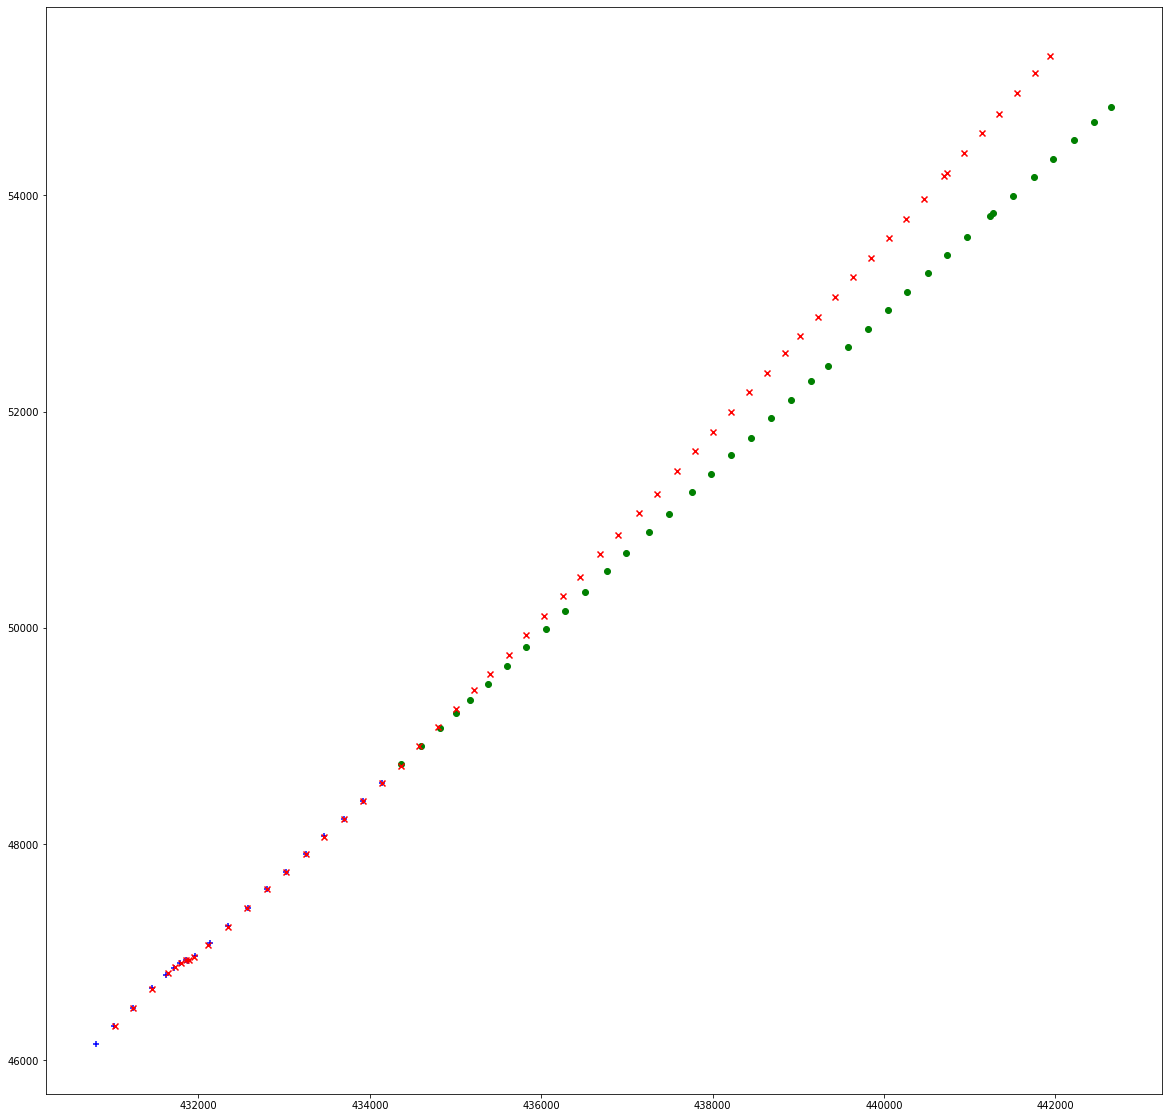

In [ ]:
#plot raw sensor observations vs filtered
n_sensor = []
e_sensor = []
n_filtered = []
e_filtered = []
n_original = []
e_original = []

# Plot observations 
for k,row in enumerate(zk_vector_holder,start = 1):
  if row[0] == 0:
    continue
  n_sensor.append(row[1])
  e_sensor.append(row[0])

# Plot "missing" observations
for k,row in enumerate(original_observations,start = 1):
  if k > 20:
    n_original.append(row[1])
    e_original.append(row[0])

# Plot Kalman predictions
for row in filtered_observations:
  n_filtered.append(row[1])
  e_filtered.append(row[0])

# Set plot size
plt.figure(figsize=(20,20))

# Sensor reading
plt.scatter(e_sensor,n_sensor, color = "blue", marker = "+")

# "Missing" observations
plt.scatter(e_original,n_original, color = "green", marker = "o")

# Kalman filter prediction
plt.scatter(e_filtered,n_filtered, color = "red", marker = "x")

# Plot positions
plt.show

pd_filtered_observations = pd.DataFrame(filtered_observations)
pd_filtered_observations.to_csv('IMO9657064_prediction.csv', header=['LAT', 'LON', 'Heading'])


38
38
[  10.589    4.245   -2.151  -32.809  -87.438  -92.471  -98.442 -111.291
 -124.778 -136.63  -144.258 -157.248 -172.236 -178.204 -187.79  -198.258
 -209.659 -219.805 -234.06  -241.387 -251.548 -259.485 -271.427 -279.23
 -293.038 -304.559 -317.315 -325.681 -340.161 -353.083 -370.564 -373.142
 -394.325 -406.553 -421.867 -435.594 -451.432 -467.975]
38
38
[  2.356  16.603  25.91   -1.696 -44.09  -30.679 -19.243  -0.555  18.049
  34.085  57.189  82.568  98.295 121.307 137.022 165.94  189.799 212.865
 233.212 260.06  285.187 307.555 325.772 354.326 381.447 407.523 429.74
 457.98  480.482 506.805 540.251 542.821 576.067 607.029 628.245 660.06
 687.677 709.859]
38
[  2.356  16.603  25.91    1.696  44.09   30.679  19.243   0.555  18.049
  34.085  57.189  82.568  98.295 121.307 137.022 165.94  189.799 212.865
 233.212 260.06  285.187 307.555 325.772 354.326 381.447 407.523 429.74
 457.98  480.482 506.805 540.251 542.821 576.067 607.029 628.245 660.06
 687.677 709.859]


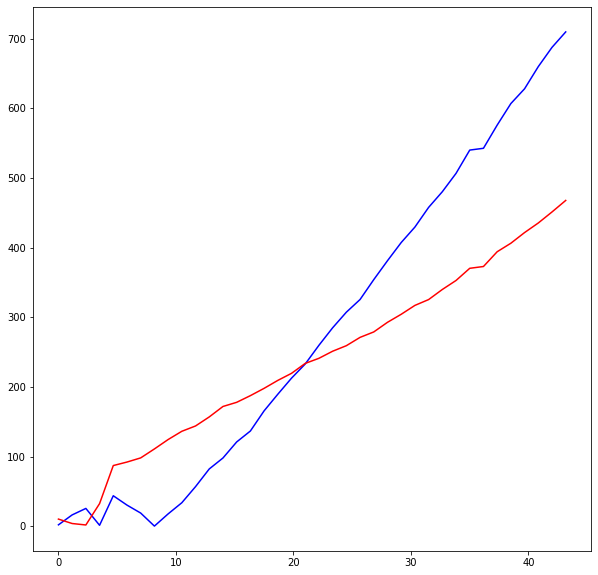

In [ ]:
# Calculate differences dx and dy in coordinates between predicted and measured positions

# Northing differences
n_original_numpy = np.array(n_original)
n_filtered_numpy = np.array(n_filtered[19:])
n_difference = n_original_numpy - n_filtered_numpy
print(len(n_original_numpy))
print(len(n_filtered_numpy))
print(n_difference)

# Easting differences
e_original_numpy = np.array(e_original)
e_filtered_numpy = np.array(e_filtered[19:])
e_difference = e_original_numpy - e_filtered_numpy
print(len(e_original_numpy))
print(len(e_filtered_numpy))
print(e_difference)

timeseries = []
start = 0
# Create time differences for time series
for i in range(len(e_original)):
  timeseries.append(start)
  start = start + 70
print(len(timeseries))
print(np.absolute(e_difference))

# convert timeseries to minutes
timeseries[:] = [x / 60 for x in timeseries]

# Plot graph which shows absolute difference for dx and dy for predicted
# points, time is in minutes
plt.figure(figsize=(10,10))
plt.plot(timeseries,np.absolute(e_difference), color = "blue")
plt.plot(timeseries,np.absolute(n_difference), color = "red")

In [ ]:
# Create final file which will hold first 20 points as original points
# and the rest will be prediction with the filter
# It will have format [E, N, Heading, Timestamp]

final_file = zk_vector_holder[0:19]

for i in range(19,len(filtered_observations)):
  final_file.append(filtered_observations[i].tolist())

# Now final file has first 20 points as recorded by AIS and the rest
# is predictions
# Now let's add time differences

for k,row in enumerate(final_file,start=1):
  row.append(time_holder[k])


In [ ]:
# Write final_file as csv

# Fields
#fields = ["E", "N", "Heading", "Time"]

# Choose filename
#filename = "IMO8940581_predicted_50_01.csv"

#with open("/content/drive/MyDrive/Master/ShipRouting/nikola_test" + filename, "w") as csvfile:
   # creating a csv writer object 
    #csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    #csvwriter.writerow(fields) 
        
    # writing the data rows 
    #csvwriter.writerows(final_file)
